<a href="https://colab.research.google.com/github/gvogiatzis/CS4740/blob/main/CS4740_Lab_Week_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS4740 Labs
## Week 2

In this lab we will be carrying out some simple Machine Learning experiments in order to gain some familiarity with the Python ML ecosystem and Pytorch in particular. We will be using the Iris dataset that consists of 150 datapoints, each with 4 measurements and belonging to one out of 3 possible classes (varieties of Iris). As we will see in class, Logistic Regression is a probabilistic model. It defines the probability of a datapoint $\mathbf{x}$ belonging to class $t$ as $$p(t|\mathbf{x},W)=y_{t}$$

where the $y_t$ are elements of the soft-max vector $$\mathbf{y}=\frac{1}{e^{\mathbf{w}_{1}^{T}\mathbf{x}}+\ldots+e^{\mathbf{w}_{C}^{T}\mathbf{x}}}\left[\begin{array}{c}
e^{\mathbf{w}_{1}^{T}\mathbf{x}}\\
\vdots\\
e^{\mathbf{w}_{C}^{T}\mathbf{x}}
\end{array}\right]$$

In this formula the $\mathbf{w}_1,\ldots,\mathbf{w}_C$ are the weights of the model with $C$ denoting the number of classes; in our case, $3$. Note that all $y_i$s are numbers between $0$ and $1$ that also add up to $1$, i.e. a probability distribution.

To estimate the values of the weights we minimize the negative log-likellihood of the data, given by

\begin{align*}
L(\mathbf{x},t;W) & =-\log p(t|\mathbf{x},W)\\
 & =-\log y_{t}\\
 & =-\log\frac{e^{\mathbf{w}_{t}^{T}\mathbf{x}}}{e^{\mathbf{w}_{1}^{T}\mathbf{x}}+\ldots+e^{\mathbf{w}_{C}^{T}\mathbf{x}}}\\
 & =\log(e^{\mathbf{w}_{1}^{T}\mathbf{x}}+\ldots+e^{\mathbf{w}_{C}^{T}\mathbf{x}})-\mathbf{w}_{t}^{T}\mathbf{x}
\end{align*}


# Section 1. Hard-coding the gradient

The negative log-likelihood in Logistic Regression is a complicated function whose minimum cannot be computed analytically. We therefore have to use approximate optimization and one of the tried and tested ways of doing this is the Gradient Descent algorithm. As we will see in class, this can be loosely summarized as:

```
while not converged:
    compute gradient of error at w
    move w along the direction of the negative gradient by a small amount
```

As we saw above, the negative log likelihood consists of two terms which we can differentiate independently. Differentiating the first term gives 

$$\begin{align*}
\nabla_{\mathbf{w_{k}}}\log(e^{\mathbf{w}_{1}^{T}\mathbf{x}}+\ldots+e^{\mathbf{w}_{C}^{T}\mathbf{x}}) & =\frac{e^{\mathbf{w}_{k}^{T}\mathbf{x}}}{e^{\mathbf{w}_{1}^{T}\mathbf{x}}+\ldots+e^{\mathbf{w}_{C}^{T}\mathbf{x}}}\mathbf{x}\\
 & =y_{k}\mathbf{x}
\end{align*}.$$

Differentiating the second term gives
$$\nabla_{\mathbf{w_{k}}}\mathbf{w}_{t}^{T}\mathbf{x}=\begin{cases}
\mathbf{x} & \textrm{if}\quad k=t\\
0 & \textrm{otherwise}
\end{cases}.$$

Adding the two together we get

$$\nabla_{\mathbf{w_{k}}}L(\mathbf{x},t;W)=\begin{cases}
(y_{k}-1)\mathbf{x} & \textrm{if}\quad k=t\\
y_{k}\mathbf{x} & \textrm{otherwise}
\end{cases}$$

for $k=1,\ldots,C$. Bear in mind this analysis was for a single data point. The negative log likelihood is added across all data-points so we need to loop through the data and add all the gradients.

First thing's first. Let's load up the dataset.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

iris = datasets.load_iris()
X = iris.data
T = iris.target

C= len(set(list(T)))
F = X.shape[1]

So we loaded the $\mathbf{x}$s in variable `X` and the labels $t$ in variable `T`. We also calculate the number of all possible classes `C` (in our case the classes are `{0,1,2}` so `C=3`) and the number of dimensions (features) in each datapoint `F` (in our case `F=4`). Now it's always a good idea to compute one term of the neg. log likelihood before we scale up to the whole thing. So let's define

In [ ]:
x=X[0]
t=T[0]

It will be very convenient to store the weights of the model in a single array `W` which has `C` rows and `F` columns. Let's initialize it randomly.

In [ ]:
W = np.random.randn(C,F)

The matrix multiplication $W \mathbf{x}$ gives the linear activations, i.e. a vector with elements $\mathbf{w}_1^T \mathbf{x},\ldots,\mathbf{w}_C^T \mathbf{x}$ before they get passed to the soft-max function. The soft-max vector itself can be computed using

In [ ]:
p = np.exp(W @ x)
y = p/sum(p)

Let's verify that it is a probability distribution

In [ ]:
print(y)
print(sum(y))

[7.75236010e-05 1.17203890e-03 9.98750437e-01]
1.0


Now the neg. log likelihood _just_ for this datapoint can be defined as 

In [ ]:
L = - np.log(y[t])

Let's now define a variable to hold the gradient of $L$ with respect to the weights, i.e. $\nabla_W L$ which we will initialize to zero. Note that it has exactly the same dimensions as $W$. 

In [ ]:
dW = np.zeros_like(W)

According to the formula we derived above

In [ ]:
for c in range(C):
    dW[c] = (y[c] - 1) * x if c==t else y[c] * x

Now all we need to do is loop through the whole dataset, adding the gradients as we go along. We will finally update the weights by adding a small negative multiple of the gradient, which is guaranteed to decrease the total neg. log likelihood by a small amount. It's also a good idea for sanity checking and general good practice, to produce some plot of the (hopefully) decreasing $L$. Adding everything together we get the following:

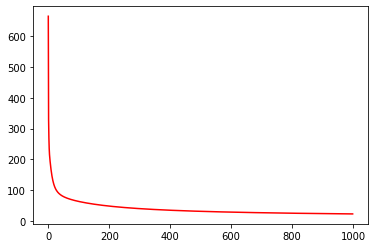

In [ ]:
Ls=[] # this array will hold the neg. log likelihood as it decreases throughout 
# the algorithm
W = np.random.randn(C,F) # Our model weights, randomly initialized
alpha = 5e-4 # The learning rate
for e in range(1000): # We will perform 1000 steps of gradient descent
  dW = np.zeros_like(W) #initialize gradient to zero
  L=0 #initialize the neg.log likelihood sum
  for x,t in zip(X,T): #loop through dataset
    p = np.exp(W @ x) #soft-max
    y = p/sum(p) 
    L += -np.log(y[t]) #add neg. log. likelihood for datapoint
    for c in range(C):# compute gradient for datapoint
        dW[c] += (y[c] - 1) * x if c==t else y[c] * x    
  W -= alpha*dW # move weights in direction oposite to gradient
  Ls.append(L) # keep record of neg. log likelihood
plt.plot(Ls,'r-') # plot trajectory of L during gradient descent **V. IMPORTANT**

Seems that we managed to decrease something! Let's see if this corresponds to some accurate predictions

In [ ]:
correct = 0
for x,t in zip(X,T):
  a_pred = W @ x
  correct += (a_pred.argmax() == t)
print(f'accuracy={correct/len(T)}')

accuracy=0.9733333333333334


That means that a pretty descent 97% of the class of all datapoints is correctly predicted by our model. (It's a pretty simple dataset after all)

# Section 2. Using Pytorch tensors

In the case of Logistic Regression the gradient can be computed easily enough. However as models get more complicated, it becomes harder, messier and more error prone, to derive gradients analytically. Eventually it becomes a stumbling block to the entire programming effort. Obtaining the gradient of the loss function automaticall is one of the primary aims of Deep Learning frameworks such as `TensorFlow` or `Pytorch`. In this section we will revisit the Logistic Regression task but this time, pretending we are not able to compute the gradients. Let's begin by importing the `Pytorch` framework and casting the data into pytorch tensors.

In [ ]:
import torch
X = torch.tensor(iris.data,dtype=torch.float32)
T = torch.tensor(iris.target,dtype=torch.long)

Let us also initialize the weight matrix $W$ as a $C\times F$ random `Pytorch` matrix. 

In [ ]:
W = torch.randn(C,F,requires_grad=True,dtype=torch.float32)

Only difference from before is this mysterious option flag `requires_grad` that is set to `True`. We will see what this does shortly.
As before, we will focus on a single datapoint $\mathbf{x},t$.

In [ ]:
x=X[0]
t=T[0]
p=torch.exp(W @ x)
y = p/sum(p)
L = -torch.log(y[t])

Again, notice how this is all identical to the equivalent `numpy` code above. The only difference being that we must call the tensor versions of `exp`, `log` etc because we are dealing with `Pytorch` tensors instead of `numpy` arrays. 

Now instead of going to the trouble of computing the gradient of $L$ with respect to $W$, we only have to execute a single (magic) line of code:

In [ ]:
L.backward()

... and we're done! Of course you will ask, where is the gradient? We didn't define any `dW` variable! The answer is that `Pytorch`, very conveniently automatically calculates the gradient and hides it in a specially defined `.grad` attribute. So in our case the gradient can be found in

In [ ]:
print(W.grad)

tensor([[-5.0361e+00, -3.4561e+00, -1.3825e+00, -1.9749e-01],
        [ 6.1235e-06,  4.2024e-06,  1.6810e-06,  2.4014e-07],
        [ 5.0361e+00,  3.4561e+00,  1.3825e+00,  1.9749e-01]])


That's pretty neat right? What's more, every time we call the `.backward()` method on a value we just computed, `Pytorch` knows that it has to calculate gradients for all tensors that played a part in that computation and these gradients are accumulated additively. All of them? I hear you ask. Well actually that would be too computationally heavy. Instead, `Pytorch` does this only for tensors that have been defined with the `requires_grad` flag set to `True`.  So we just need to remember to set that flag for all model parameters, all tensors we would like to modify in order to minimize our loss function.

All this basically means that the only thing we need to do is come up with the appropriate loss function for a dataset and problem, write down the code that computes it (known as the _forward step_) and `Pytorch` will calculate the gradients (known as the _backward step_).  I hope you take a moment to apreciate just how wonderfully elegant the scheme is!

Putting everything in a loop around the dataset we now get code that looks like the following:

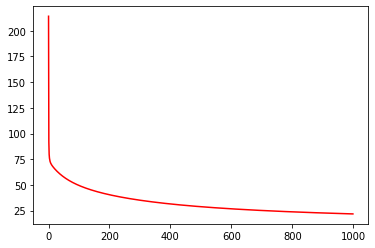

In [ ]:
Ls=[]

W = torch.randn(C,F,requires_grad=True,dtype=torch.float32)
alpha = 5e-4
for e in range(1000):
  Ltot = 0.0
  for x,t in zip(X,T):
    p=torch.exp(W @ x)
    y = p/sum(p)
    L = -torch.log(y[t])
    L.backward() # This is where all the magic happens
    Ltot += L.item()
  W.data -= alpha*W.grad # gradient descent step
  W.grad.data.zero_() # we need to remember to set the gradient to zero (pytorch)
                      # cannot know when our loss function computation is complete
  Ls.append(Ltot)
plt.plot(Ls,'r-')

# Section 3. Using Pytorch Neural Network layers

Now we are ready to see some more `Pytorch` awesomeness. The developers of the framework have already included a wide range of classes that pre-define a lot of the building blocks of Deep Learning. We therefore rarely have to define loss functions from first principles (using `exp`, `log` and suchlike). Instead we can rely on ready made building blocks that can be efficiently connected to one and other. And once again, `Pytorch` will automatically compute gradients for us.

For Logistic Regression the only ingredient we need is a `Linear` layer, that plays the role of the $W$ matrix we had before. The loss function can be defined using the `CrossEntropyLoss` class.

In [ ]:
W = torch.nn.Linear(F,C)
loss = torch.nn.CrossEntropyLoss(reduction='sum')

All `Pytorch` layers (including loss functions) can be used as functions on tensors, producing other tensors as results. So the function call 

```W(X)``` 

maps each of the 4D row vector elements of tensor `X` to a 3D output vector by multiplying by a weight matrix and addind a bias $b$ to the result. The loss function takes the output of `W` and the correct labels `T` and computes the total negative log likelihood

In [ ]:
L = loss(W(X),T)

all in a single line of code! Now we can execute `backward()` function as before. 

In [ ]:
L.backward()

Yet another convenience that `Pytorch` provides is the simplification of the gradient descent code. After all, there should be an easy way to abstract away what is always going to be the same line of code, i.e. taking the model parameter and subtracting its gradient (to be found in `.grad`) times the learning rate. And indeed that's what `Pytorch` offers. All we need to define is an optimizer object (in our case implementing Stochastic Gradient Descent, but there are many other variants) give it pointers to the parameters that should be optimized as well as a learning rate. All this is accomplished by 

In [ ]:
optim = torch.optim.SGD(W.parameters(), lr=5e-4)

Putting everything together gives us

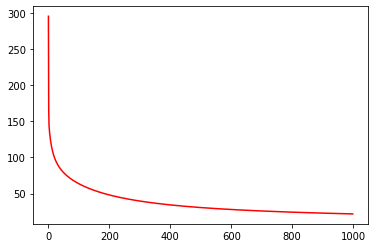

In [ ]:
X = torch.tensor(iris.data,dtype=torch.float32)
T = torch.tensor(iris.target,dtype=torch.long)

W = torch.nn.Linear(F,C)
loss = torch.nn.CrossEntropyLoss(reduction='sum')
optim = torch.optim.SGD(W.parameters(), lr=5e-4)

Ls=[]
for e in range(1000):
  optim.zero_grad()
  L = loss(W(X),T)
  L.backward()
  optim.step()
  Ls.append(L.item())
plt.plot(Ls,'r-')

To compute the accuracy of the predictions all we need is to use the `.topk` method that returns the values and indices of the top $K$ elements along a particular dimension in a tensor.

In [ ]:
_,T_pred = W(X).topk(1)
acc=(T_pred.flatten()==T).sum(dtype=torch.float) / len(T)
print(f'accuracy={acc}')

accuracy=0.9800000190734863



I hope this lab has given you a taste of some of the things one can achieve with relatively little effort, using some of the existing `Python` machinery for Machine Learning. You can find lots more information in the super-helpful `Pytorch` doc pages. 

## Challenge:

Can you apply your model to the __breast cancer__ and __wine__ datasets? They can be loaded using

```sklearn.datasets.load_breast_cancer()```

and

```sklearn.datasets.load_wine()```

What accuracies can you get?


# Appendix. Using sklearn

For completeness, here's how you would achieve the same task using existing ML software libraries (`sklearn`). These frameworks are great for employing off-the-shelf models, but are not very helpfull for building more complex models or researching completely novel machine learning architectures.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
estimator = LogisticRegression()
estimator.fit(X,T)

In [ ]:
T_pred = estimator.predict(X)
acc = accuracy_score(T,T_pred)
print(acc)

0.9733333333333334
